## Genetic Algorithm for discovering best design given stats inputs

We generate two fMRI designs, then we leverage Genetic Algorithm Crossover to generate a third hybrid fMRI design optimized for metrics.

---

## Credit

Note: This notebook is an extension of Neurodesign's [examples](https://github.com/neuropower/neurodesign/blob/master/examples/comparison_neurodesign.ipynb).

### 📋 Experimental Setup
We define an experiment with the following parameters:
* Repetition Time (TR): 1.2s — This is the temporal resolution of the fMRI acquisition.
* Number of Trials: 20 — A short toy design for demonstration, later extended.
* Stimulus Conditions: 3 — Each trial presents one of three task conditions.
* Condition Probabilities: [0.3, 0.3, 0.4] — Slightly higher representation of the third condition.
* Contrasts: Two pairwise comparisons: Condition 1 vs 2, and Condition 2 vs 3.
* Stimulus Duration: 1s — Short stimulus presentations.
* Autocorrelation (ρ): 0.3 — Assumes moderate temporal correlation in the fMRI noise.
* ITI Model: Uniform between 2s and 4s — Models a simple jittered baseline period.

These parameters are passed into a neurodesign.Experiment object, which encapsulates the statistical and temporal characteristics of the design.

---

### 🧪 Design 1 and Design 2: Efficiency Comparison
Two specific trial sequences (i.e., orders) are evaluated:

1. Design 1: A rotating sequence [0, 1, 2, ...] with all three conditions repeating in succession. ITIs are fixed at 2s.
2. Design 2: A block design with clusters of the same condition (e.g., 5 trials of condition 0, then 5 of condition 1, etc.).

We compute the following for each design:
* The convolved design matrix, representing how the experimental manipulation maps onto BOLD responses over time.
* The detection efficiency (Ff) and estimation efficiency (Fd) — two standard metrics from statistical design theory:
* Ff assesses how well the design detects condition differences.
* Fd assesses how well it estimates the shape of the hemodynamic response.

---

### 🔁 Genetic Algorithm Crossover
We simulate a genetic crossover between Design 1 and Design 2. This mimics evolutionary recombination: two parent designs produce offspring by combining trial order information. This step demonstrates how new designs can be generated during optimization.

We also generate:
* A random order of 100 trials across 4 conditions with equal probabilities.
* A set of exponentially distributed ITIs (mean = 3s, bounded between 2s–8s) to create jitter for de-correlating neural events in the GLM.

This illustrates how to simulate more realistic, variable-timing designs, which increase design efficiency.

---

### 🧬 Full Design Optimization
Finally, we use neurodesign.Optimisation to simulate evolutionary design optimization. The genetic algorithm iteratively selects and mutates trial sequences to improve a weighted sum of efficiency metrics:
* weights=[0.5, 0.25, 0, 0.25] emphasizes:
* 0.5: Estimation efficiency (Fe)
* 0.25: Detection power (Fd)
* 0.0: Stimulus frequency match (unused in this run) (Fc)
* 0.25: Confound reduction and frequency balancing (Ff)

The optimizer runs for a number of cycles (preruncycles=10, cycles=100), gradually converging toward a design that is statistically superior in terms of detecting and estimating BOLD responses for the specified contrasts.

---

## Initial Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neurodesign

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Define experiment setup

In [3]:
from collections import Counter
from pathlib import Path
from rich import print

# ------------------------
# DEFINE EXPERIMENT SETUP
# ------------------------

# Create an Experiment object defining general fMRI design parameters
exp = neurodesign.Experiment(
    TR=1.2,               # Repetition Time (TR) in seconds
    n_trials=20,          # Total number of trials
    P=[0.3, 0.3, 0.4],    # Probabilities for each of the 3 conditions
    C=[[1, -1, 0],        # Contrasts of interest (e.g., cond1 vs cond2)
       [0, 1, -1]],       # and cond2 vs cond3
    n_stimuli=3,          # Number of stimulus/conditions
    rho=0.3,              # Autocorrelation of the noise in fMRI signal
    stim_duration=1,      # Duration of each stimulus/event
    ITImodel="uniform",   # Inter-trial interval (ITI) distribution
    ITImin=2,             # Minimum ITI
    ITImax=4              # Maximum ITI
)

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:635: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.09999999999999999
  warnings.warn(
c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\neurodesign\classes.py:809: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


We first define two experimental designs: alterntting conditions (Design 1) vs block conditions (Design 2)

## Create and evaluate designs

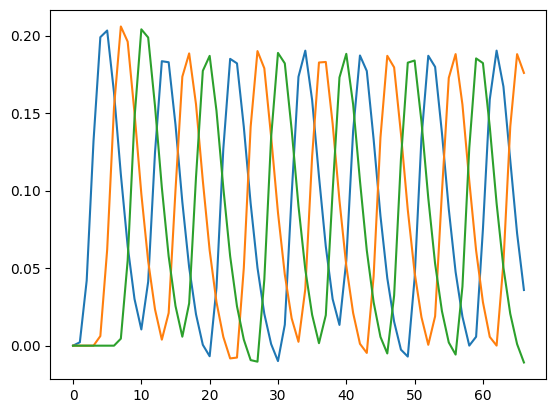

In [4]:
# ------------------------
# CREATE AND EVALUATE DESIGNS
# ------------------------

# Design 1: alternating conditions with fixed ITIs
design_1 = neurodesign.Design(
    order=[0, 1, 2] * 6 + [0, 1],  # Trial condition sequence (20 trials)
    ITI=[2] * 20,                 # Constant ITI of 2s for each trial
    experiment=exp
)
design_1.designmatrix()           # Generate design matrix and convolve with HRF
design_1.FCalc(weights=[0.25, 0.25, 0.25, 0.25])  # Compute design optimality metrics

plt.plot(design_1.Xconv)         # Plot the convolved design matrix (with HRF)


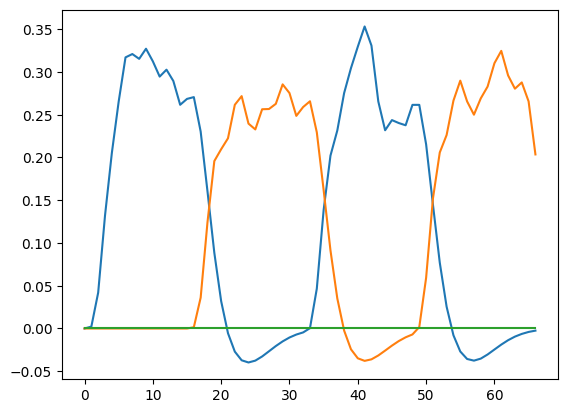

In [5]:
# ------------------------
# CREATE AND EVALUATE DESIGNS
# ------------------------

# Design 2: blocked condition structure
design_2 = neurodesign.Design(
    order=[0]*5 + [1]*5 + [0]*5 + [1]*5,  # Blocked sequence of conditions
    ITI=[2] * 20,                        # Constant ITI
    experiment=exp
)
design_2.designmatrix()             # Generate design matrix and convolve with HRF
design_2.FCalc(weights=[0.25, 0.25, 0.25, 0.25])  # Compute design optimality metrics

plt.plot(design_2.Xconv)         # Plot the convolved design matrix (with HRF)

In [11]:
# Print optimality metrics (from FCalc): Ff = detection, Fd = estimation
print(f"Fe of design 1: {str(design_1.Fe)}")
print(f"Fe of design 2: {str(design_2.Fe)}")
print(f"Fd of design 1: {str(design_1.Fd)}")
print(f"Fd of design 2: {str(design_2.Fd)}")

Fe of design 1: 142.6383217799004

Fe of design 2: 117.82644042448676

Fd of design 1: 0.14027878036113348

Fd of design 2: 0.155472832178427

1. Fe – Estimation Efficiency: This measures how well the design allows for precise estimation of the shape and amplitude of the HRF (hemodynamic response) for each condition.
* Fe (design 1): 142
* Fe (design 2): 117

A higher Fe indicates less correlated regressors, and thus better parameter estimation.  

2. Fd – Detection Power: This metric reflects the ability to detect condition differences (i.e., statistical power for contrasts).
* Fd (design 1): 0.14
* Fd (design 2): 0.15

A higher Fd means greater detection sensitivity for condition effects.  

Next, we use genetic algorithm crossover to find the design that optimizes both Ff and Fd.

## Generate random order

In [12]:
# ------------------------
# GENERATE RANDOM ORDER
# ------------------------

# Generate a random stimulus order for 4 conditions and 100 trials
order = neurodesign.generate.order(
    nstim=4,
    ntrials=100,
    probabilities=[0.25, 0.25, 0.25, 0.25],  # Equal distribution
    ordertype="random",
    seed=1234
)
print(order[:10])          # Print first 10 items of generated order
Counter(order)             # Count occurrences of each condition

[3, 0, 0, 2, 0, 0, 2, 2, 2, 0]

Counter({0: 36, 2: 22, 1: 22, 3: 20})

## Generate jittered ITI

In [13]:
# ------------------------
# GENERATE JITTERED ITI
# ------------------------

# Generate exponential ITIs with bounds
iti, lam = neurodesign.generate.iti( # lam : lambda, parameter for exponential
    ntrials=40,
    model="exponential",
    min=2,
    mean=3,
    max=8,
    resolution=0.1,
    seed=2134
)

print(iti[:10])            # Show the first 10 ITIs
print(
    f"mean ITI: {round(sum(iti) / len(iti), 2)}\n"
    f"min ITI: {round(min(iti), 2)}\n"
    f"max ITI: {round(max(iti), 2)}\n"
)

[0.  2.  2.1 2.  2.  2.  5.4 2.  2.4 5.1]

mean ITI: 2.92
min ITI: 0.0
max ITI: 6.9

## Run genetic optimization

In [14]:
# ------------------------
# RUN GENETIC OPTIMIZATION
# ------------------------

# Optimize designs using genetic algorithm
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fd, Ff, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

c:\Users\vguigon\Desktop\Research_directory\research_tests\neurodesign-plus\venv\Lib\site-packages\rich\live.py:231
: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

We can now observe the best design. First let's take a look at the metrics:

## Inspect best design

In [15]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fe (estimation efficiency): {best_design.Fe}")
print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Ff (stimulus frequency balance): {best_design.Ff}")


Fe (estimation efficiency): 0

Fd (detection efficiency): 0.9729553229433273

Fc (confounding): 0.7086882453151618

Ff (stimulus frequency balance): 0.9285714285714286

We can see that the new design outperforms Design 1 and Design 2 on the Fd metrics.  
However, estimation efficiency is absent, and there is still moderate-to-high confounding between the different conditions' timecourses. Ideally, we would want Fc as close to 0 as possible.  

We obtain a design matrix with 67 timepoints/TRs (duration in TR) and 3 regressors, 1 per condition.  
We can have a look at the design matrix below.

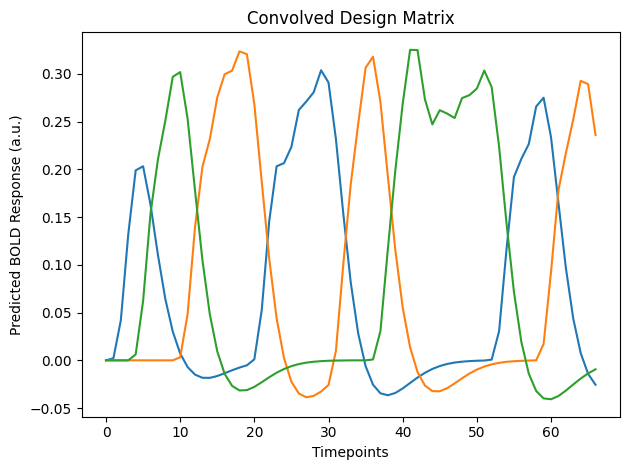

In [16]:
plt.plot(best_design.Xconv)
plt.title("Convolved Design Matrix")
plt.xlabel("Timepoints")
plt.ylabel("Predicted BOLD Response (a.u.)")
plt.tight_layout()
plt.show()

In [17]:
print("Shape of Xconv:", best_design.Xconv.shape)

Shape of Xconv:
(67, 3)

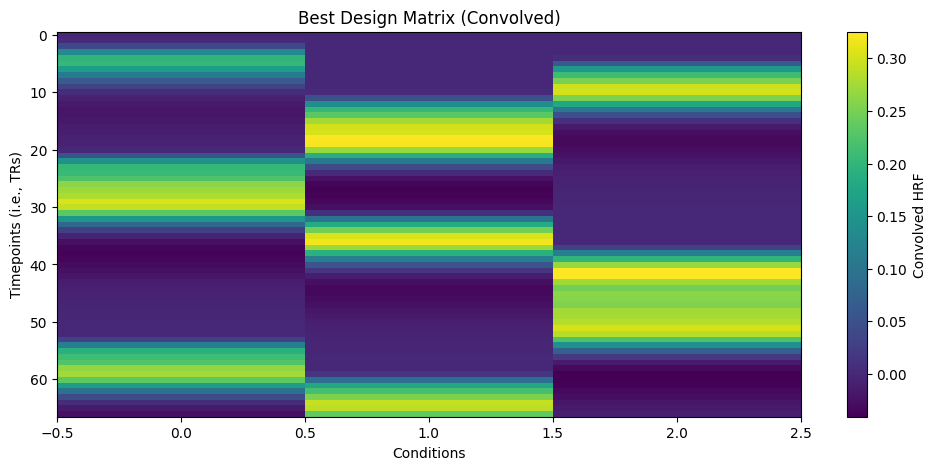

In [18]:
best_design.designmatrix()
plt.figure(figsize=(12, 5))
plt.imshow(best_design.Xconv, aspect='auto', cmap='viridis')
plt.colorbar(label='Convolved HRF')
plt.title("Best Design Matrix (Convolved)")
plt.xlabel("Conditions")
plt.ylabel("Timepoints (i.e., TRs)")
plt.show()

We can have a look at the distribution of ITI below:

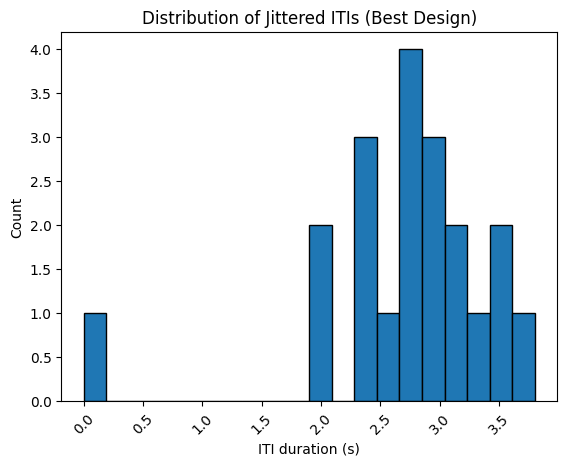

In [19]:
plt.hist(best_design.ITI, bins=20, edgecolor='black')
plt.title("Distribution of Jittered ITIs (Best Design)")
plt.xlabel("ITI duration (s)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

And we can ask get the stimuli order and corresponding ITI of the best design, as below:

In [20]:
print("Stimulus order:", best_design.order)
print("ITI sequence:", best_design.ITI)

Stimulus order:
[
    0,
    np.int32(2),
    np.int64(2),
    np.int64(1),
    np.int64(1),
    np.int32(1),
    np.int64(0),
    np.int64(0),
    np.int64(0),
    np.int64(1),
    np.int64(1),
    np.int64(2),
    np.int64(2),
    np.int64(2),
    np.int64(2),
    np.int64(2),
    0,
    0,
    1,
    1
]

ITI sequence: [0.  2.3 2.7 2.7 2.9 2.5 3.5 3.6 2.7 3.1 2.3 2.9 2.  3.8 2.8 2.4 3.1 3.4
 2.  2.9]